In [40]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import skimage.color
import skimage.io
import tensorflow as tf
from tensorflow.python.keras import Model

from chroma_instance.config.FirstTest import FirstTestConfig
from chroma_instance.data.generator_single_file import DataSingleFile
from chroma_instance.model.fusion_with_instance import FusionModel, pack_instance

tf.enable_eager_execution()

In [2]:
config = FirstTestConfig('instance', ROOT_DIR='../../../')
config.BATCH_SIZE = 1
config.PRETRAINED = 'fusion_combinedEpoch9.h5'

save_path = os.path.join(config.MODEL_DIR, config.PRETRAINED)
fusion_model = FusionModel(config)
fusion_model.combined.load_weights(save_path)

In [8]:
config.TEST_DIR = "imagenet_ctest"
test_data = DataSingleFile(config.TEST_DIR, "ILSVRC2012_val_00033944.JPEG", config)
batch = test_data.generate_batch()
batch_X = batch.resized_images.l
batch_Y = batch.resized_images.ab

print(fusion_model.combined.summary())

Model: "combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fg_img_l (InputLayer)           [(None, 224, 224, 1, 0                                            
__________________________________________________________________________________________________
fusion_img_l (InputLayer)       [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 28, 28, 512, 47528866    fg_img_l[0][0]                   
__________________________________________________________________________________________________
fg_bbox (InputLayer)            [(None, 4, 2)]       0                                            
___________________________________________________________________________________________

In [12]:
fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17, upsampling = fusion_model.foreground_generator.predict(
    batch.instances.l)

fusion_img_pred_ab, _ = fusion_model.fusion_generator.predict(
    [batch.resized_images.l, fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17,
     batch.instances.bbox, batch.instances.mask])

Total instances: 4


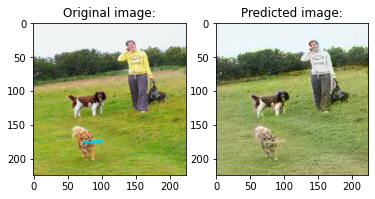

In [50]:
print(f"Total instances: {batch.object_n[0]}")

plt.subplot(1, 2, 1)
plt.title("Original image:")
original_rgb = batch.images.full[:, :, :, [2, 1, 0]][0]
plt.imshow(skimage.transform.resize(original_rgb, (224, 224)))
plt.imsave('../../../../figs/full_original.jpg', skimage.transform.resize(original_rgb, (224, 224)))
plt.subplot(1, 2, 2)
plt.title("Predicted image:")
lab = tf.concat((batch.resized_images.l[0], fusion_img_pred_ab[0]), -1)
rgb = cv2.cvtColor(np.clip(lab*255, 0, 255).astype(np.uint8), cv2.COLOR_Lab2RGB)
plt.imsave('../../../../figs/full_predicted.jpg', rgb)
plt.imshow(rgb)
plt.show()

upsampling has shape: (1, 224, 224, 2, 2)


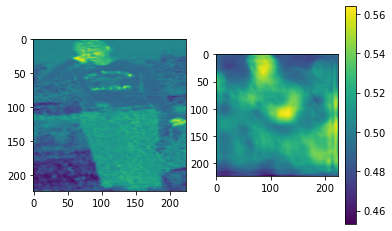

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(batch.instances.ab[0, :, :, 0, 0])

plt.subplot(1, 2, 2)
print(f"upsampling has shape: {upsampling.shape}")
slice = upsampling[0, :, :, 1, 0]
plt.imshow(slice)
plt.colorbar()
plt.show()

In [30]:
print(fusion_model.fusion_generator.summary())

conv2d_15_extractor = Model(
    inputs=fusion_model.fusion_generator.input,
    outputs=fusion_model.fusion_generator.get_layer(name='conv2d_15').output
)

conv2d_15 = conv2d_15_extractor.predict([batch.resized_images.l, fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17,
     batch.instances.bbox, batch.instances.mask])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_tile (Lambda)             (None, 224, 224, 3)  0           input_img[0][0]                  
__________________________________________________________________________________________________
fg_model_3 (InputLayer)         [(None, 28, 28, 512, 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 28, 28, 512)  7635264     input_tile[0][0]                 
____________________________________________________________________________________________

In [32]:
weight4_generator = fusion_model.fusion_generator.get_layer(name='weight_generator_4')

fg_conv2d_15_packed = np.squeeze(
    np.reshape(
        np.transpose(
            fg_conv2d_15,
            axes=[0, 4, 1, 2, 3]),
        (-1, 1, *fg_conv2d_15.shape[1:-1])),
    axis=1)
instance_weights = weight4_generator.instance_conv(fg_conv2d_15_packed)
background_weights = weight4_generator.simple_bg_conv(conv2d_15)

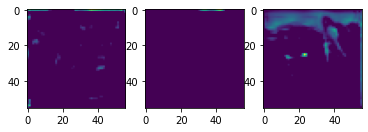

In [34]:
plt.subplot(1, 3, 1)
plt.imshow(fg_conv2d_15[0, :, :, 0, 0])

plt.subplot(1, 3, 2)
plt.imshow(fg_conv2d_15[0, :, :, 0, 1])

plt.subplot(1, 3, 3)
plt.imshow(conv2d_15[0, :, :, 0])

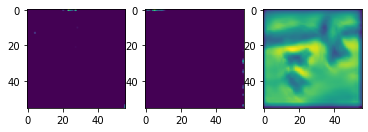

In [33]:
plt.subplot(1, 3, 1)
plt.imshow(instance_weights[0, :, :, 0])

plt.subplot(1, 3, 2)
plt.imshow(instance_weights[1, :, :, 0])

plt.subplot(1, 3, 3)
plt.imshow(background_weights[0, :, :, 0])

In [35]:
conv2d_17_extractor = Model(
    inputs=fusion_model.fusion_generator.input,
    outputs=fusion_model.fusion_generator.get_layer(name='conv2d_17').output
)

conv2d_17 = conv2d_17_extractor.predict([batch.resized_images.l, fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17,
     batch.instances.bbox, batch.instances.mask])

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_model_3_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_11_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_13_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_15_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_17_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: bbox:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: mask:0


In [36]:
weight5_generator = fusion_model.fusion_generator.get_layer(name='weight_generator_5')

fg_conv2d_17_packed = np.squeeze(
    np.reshape(
        np.transpose(
            fg_conv2d_17,
            axes=[0, 4, 1, 2, 3]),
        (-1, 1, *fg_conv2d_17.shape[1:-1])),
    axis=1)
instance_weights = weight5_generator.instance_conv(fg_conv2d_17_packed)
background_weights = weight5_generator.simple_bg_conv(conv2d_17)

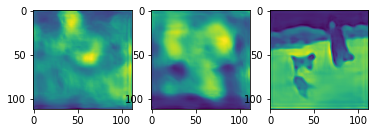

In [45]:
plt.subplot(1, 3, 1)
plt.imshow(fg_conv2d_17[0, :, :, 1, 0])

plt.subplot(1, 3, 2)
plt.imshow(fg_conv2d_17[0, :, :, 1, 1])

plt.subplot(1, 3, 3)
plt.imshow(conv2d_17[0, :, :, 1])

plt.imsave('../../../../figs/instance0_weights.jpg', fg_conv2d_17[0, :, :, 1, 0], cmap=plt.cm.YlGn)
plt.imsave('../../../../figs/instance1_weights.jpg', fg_conv2d_17[0, :, :, 1, 1], cmap=plt.cm.YlGn)
plt.imsave('../../../../figs/full_intermediate.jpg', conv2d_17[0, :, :, 1], cmap=plt.cm.YlGn)

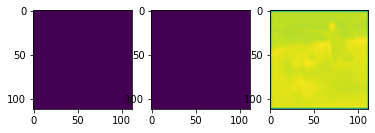

In [46]:
plt.subplot(1, 3, 1)
plt.imshow(instance_weights[0, :, :, 0])

plt.subplot(1, 3, 2)
plt.imshow(instance_weights[1, :, :, 0])

plt.subplot(1, 3, 3)
plt.imshow(background_weights[0, :, :, 0])

plt.imsave('../../../../figs/full_weights.jpg', background_weights[0, :, :, 0], cmap=plt.cm.YlGn)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_model_3_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_11_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_13_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_15_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: fg_conv2d_17_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: bbox:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: mask:0


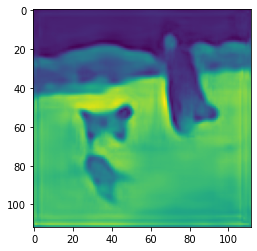

In [49]:
w5_extractor = Model(
    inputs=fusion_model.fusion_generator.input,
    outputs=fusion_model.fusion_generator.get_layer(name='weight_generator_5').output
)

w5 = w5_extractor.predict([batch.resized_images.l, fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17,
     batch.instances.bbox, batch.instances.mask])

plt.imshow(w5[0, :, :, 1])
plt.imsave('../../../../figs/combined_feature.jpg', w5[0, :, :, 1], cmap=plt.cm.YlGn)